## Example script: training and predicting with ConvLSTM
Author          : SSI project team Wadden Sea <br>
Description     : This notebook serves as an example of training and predicting with
                  Convolutional Long-Short Term Memeory Neural Network (ConvLSTM). <br>
Dependency      : os, numpy, pytorch <br>
Return Values   : array <br>
Caveat!         : This module performs many-to-one prediction! It supports CUDA. <br>


In [1]:
#This simulation with gpu (with the below parameters) took 14h

In [2]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional
from torch.autograd import Variable
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib as mpl
import glob
import xarray as xr
import dask as da
from tqdm import tqdm


# import convlstm
sys.path.append("../../../src")
import convlstm

In [3]:
#path to files-------
homee = "/export/lv4/user/jfajardourbina/"
dir_post_proc_data=f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/machine_learning_github/Lagrangian_ML/post_proc_data/"
dir_displacement="net_displacement"
dir_interp_wind="wind"

#for output after train and test---
exp="exp2e"
dir_convlstm_model_out="ouput_convlstm_model_data/"
case_train="training"; file_out_train=f"{exp}_train.nc"
case_test="testing"; file_out_test=f"{exp}_test.nc"

In [4]:
#for plotting--------
#dir_wind="{homee}dws_ulf_getm_2D_depth_avg/data/atmosphere/" #winds
dir_dws_bound=f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_dws_boundaries/" #DWS boundarie with contour0
file_dws_bound0="dws_boundaries_contour0.nc"
file_grid=f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/analysis_eulerian_data_36years/data_bathy_grid/" #topo data
#dir_vel = f'{homee}dws_ulf_getm_2D_depth_avg/data/velocity/' #vel data
#file_vel="RE.DWS200m.uvz.20090301.nc" #any vel file
#file_wind="UERRA.2009.nc4" #any wind file
#
#savee='everyM2' #saving track data every m2
#deploy='everyM2'#deploy set of particles every m2
#minTsim=60 #mimimum time of simulation (days)
#maxTsim=91 #maximum time of simulation (days)
#dir_tracks = f"{homee}dws_ulf_getm_2D_depth_avg/experiments_post_proc/lagrangian_simulation_36years/exp-deployHighVolume_coords-xcyc_save-{savee}_deploy-{deploy}_Tsim-{minTsim}-{maxTsim}d/tracks/"
#
#parameters
#npa_per_dep=12967 #number of particles per deployment
m2=int(12.42*3600+2) #period in seconds
#dx=400/1e3;dy=400/1e3 #particle grid reso

#open DWS contours
dsb0=xr.open_dataset(dir_dws_bound+file_dws_bound0) 
bdr_dws0=dsb0.bdr_dws.values #points that define DWS with contour0

#open topo file
dsto=xr.open_dataset(file_grid+"DWS200m.2012.v03.nc") 
xct0=dsto.xc.min().values/1e3; yct0=dsto.yc.min().values/1e3 #=(0,0)
mask_topo=dsto.bathymetry.copy(); mask_topo=xr.where(np.isfinite(mask_topo),1,0) #mask ocean=1, land=0

### Hyper-parameter of neural network

In [5]:
run_model = False #True = run model; False = open results from old run
input_channels = 2 # number of input channels: u10,v10 wind
output_channels = 2 #number of output channels: dx, dy displacement
hidden_channels = [6, 3, output_channels] # the last digit is the output channel of each ConvLSTMCell (so we are using 3 layers)
#hidden_channels = [4, output_channels] # the last digit is the output channel of each ConvLSTMCell (so we are using 2 layers)
kernel_size = 3 #3, does not work with kernel=2
batch_size = 1 #not used in this tutorial
num_epochs = 3000 #100
#learning parameters:
adaptive_learning=True  #False: lr=learning_rate;  True: lr=[learning_rate - learning_rate_end]
#learning_rate = 0.0025 #too slow convergence if used since the beginning of simulation
learning_rate = 0.01 #initial lr
learning_rate_end=0.0025 #final lr
#
#if: hidden_channels = [6, 3, output_channels]
#the model will create 6GB of data in GPU memory after 400 training time steps
#so, after nt_steps=2000 (around 3y) we will exceed the mem limit of GPU (around 30GB)
#2.5years for training needs approx 26GB for the above model and with: input_channels = 2; output_channels = 2; kernel_size = 3
#this is because in every time step the graph of computations is stored in the cummulative lost (after calling the model), to perform then a backpropagation
#for this reason is sometimes important to use mini_batches and perform backpropagation after finish with 1.
#then use the next mini_batch and so on until using all the data and finishes 1 eppoch.

### Hardware info and version of pytorch

In [6]:
print ("Pytorch version {}".format(torch.__version__))
# check if CUDA is available
use_cuda = torch.cuda.is_available()
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))
#print(f"{torch.cuda.get_device_name(0)}")

Pytorch version 1.8.1
Device to be used for computation: cpu


In [7]:
# import random
# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0)

### Open files

In [8]:
#open net displacement files---
files_displacement=sorted(glob.glob(f'{dir_post_proc_data}{dir_displacement}/*.nc',recursive=True))
#files_displacement=files_displacement[29:31]
#concat all the files
dsdis=xr.open_mfdataset(files_displacement,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets
#dsdis

In [9]:
#open interp files for wind---
files_interp_wind=sorted(glob.glob(f'{dir_post_proc_data}{dir_interp_wind}/*.nc',recursive=True))
#files_interp_wind=files_interp_wind[29:31]
#concat all the files
dswi=xr.open_mfdataset(files_interp_wind,concat_dim="time",parallel='True',chunks={'time': -1},
                      decode_cf=True, decode_times=True)#.load() #this are default decodes
                      #data_vars='minimal', coords='minimal', compat='override') #takes 1second more with this, see https://xarray.pydata.org/en/stable/io.html#reading-multi-file-datasets
#dswi

In [10]:
# please specify output path for the model
# output_path = './model'
# if not os.path.exists(output_path):
#    os.makedirs(output_path, exist_ok = True)

### Format data

In [11]:
#set training data---
#
#wind (input)
#dswi_train=dswi.sel(time=slice("2009-10-01","2009-12-31"),x=slice(60000,80000),y=slice(60000,70000))
#dswi_train=dswi_train.fillna(0) #fill nan with 0s in case displacement is in land (not neccesary for the above small domain)
#in_u10_train,in_v10_train=da.compute(dswi_train.u10.values.astype('float32'),dswi_train.v10.values.astype('float32'))
#
#displacement (output)
#dsdis_train=dsdis.sel(time=slice("2009-01-01","2012-12-31"))#,x=slice(70000,80000),y=slice(60000,70000))
#dsdis_train=dsdis.sel(time=slice("2009-10-01","2009-12-31"))#,x=slice(70000,80000),y=slice(60000,70000))
dsdis_train=dsdis.sel(time=slice("2009-06-01","2011-12-31"))#,x=slice(70000,80000),y=slice(60000,70000))#dsdis_train=dsdis_train.fillna(0) #fill nan with 0s in case displacement is on land (not neccesary for the above small domain)
dx_train,dy_train=da.compute(dsdis_train.dx.values.astype('float32'),dsdis_train.dy.values.astype('float32'))
#
#use the past displacement to predict the displacement after M2=12.42h
in_u10_train,in_v10_train=dx_train[0:-1,...],dy_train[0:-1,...]
out_dx_train,out_dy_train=dx_train[1:,...],dy_train[1:,...]
#
del dx_train,dy_train
times_train=dsdis_train.time[0:-1].values
nt_train,ny,nx=out_dx_train.shape
print(times_train[[0,-1]],out_dx_train.shape)

['2009-06-01T03:04:00.000000000' '2011-12-31T01:19:08.000000000'] (1823, 133, 304)


In [12]:
#set testing data---
#
#wind (input)
#dswi_test=dswi.sel(time=slice("2009-10-01","2009-12-31"),x=slice(60000,80000),y=slice(60000,70000))
#dswi_test=dswi_test.fillna(0) #fill nan with 0s in case displacement is in land (not neccesary for the above small domain)
#in_u10_test,in_v10_test=da.compute(dswi_test.u10.values.astype('float32'),dswi_test.v10.values.astype('float32'))
#
#displacement (output)
#dsdis_test=dsdis.sel(time=slice("2013-01-01",None))#,x=slice(70000,80000),y=slice(60000,70000))
#dsdis_test=dsdis.sel(time=slice("2010-01-01","2010-03-31"))#,x=slice(70000,80000),y=slice(60000,70000))
dsdis_test=dsdis.sel(time=slice("2012-01-01",None))#,x=slice(70000,80000),y=slice(60000,70000))
dx_test,dy_test=da.compute(dsdis_test.dx.values.astype('float32'),dsdis_test.dy.values.astype('float32'))
#
#use the past displacement to predict the displacement after m2
in_u10_test,in_v10_test=dx_test[0:-1,...],dy_test[0:-1,...]
out_dx_test,out_dy_test=dx_test[1:,...],dy_test[1:,...]
#
del dx_test,dy_test
times_test=dsdis_test.time[0:-1].values
nt_test,ny,nx=out_dx_test.shape
print(times_test[[0,-1]],out_dx_test.shape)

['2012-01-01T02:09:36.000000000' '2015-10-31T11:20:32.000000000'] (2705, 133, 304)


In [13]:
#for plotting maps of predictions---
#mask: ocean=1, land=nan
mask=out_dx_train[0,...]*1.; mask[np.isfinite(mask)]=1.; mask[np.isnan(mask)]=np.nan
xx=dsdis_train.x/1e3; yy=dsdis_train.y/1e3; xx,yy=np.meshgrid(xx,yy)

#for masking values on land when computing loss---
mask_torch=torch.tensor(np.where(np.isnan(mask),0,1)[np.newaxis,np.newaxis,...]*np.ones((output_channels,ny,nx)))*1.
mask_numpy=mask_torch.numpy()*1.

In [14]:
#check hist of input training and input testing data---

In [26]:
a=in_u10_train.flatten(); b=in_v10_train.flatten()

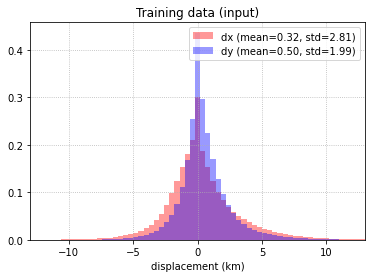

In [15]:
plt.hist(a, bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'dx (mean={np.nanmean(a):.2f}, std={np.nanstd(a):.2f})');
plt.hist(b, bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'dy (mean={np.nanmean(b):.2f}, std={np.nanstd(b):.2f})');
plt.xlim(-13,13); plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("displacement (km)");

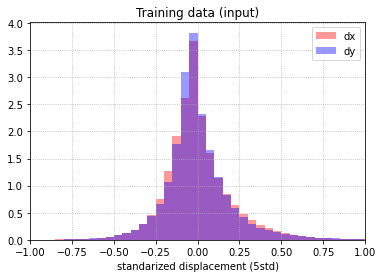

In [34]:
plt.hist((a-np.nanmean(a))/(5*np.nanstd(a)), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'dx');
plt.hist((b-np.nanmean(b))/(5*np.nanstd(b)), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'dy');
plt.xlim(-1,1); plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("standarized displacement (5std)");
#del a,b

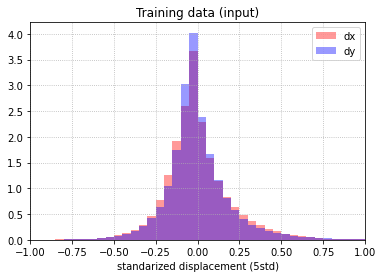

In [35]:
#So, with (minmax_scalar - its mean)*3.5 is similar than standarization with 5
#So, use standarization as it is easier to explain
a0=(a-np.nanmin(a))/(np.nanmax(a)-np.nanmin(a));a0=(a0-np.nanmean(a0))*3.5
b0=(b-np.nanmin(b))/(np.nanmax(b)-np.nanmin(b));b0=(b0-np.nanmean(b0))*3.5
plt.hist(a0, bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'dx');
plt.hist(b0, bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'dy');
plt.xlim(-1,1); plt.legend(); plt.grid(ls=":")
plt.title("Training data (input)");plt.xlabel("standarized displacement (5std)");

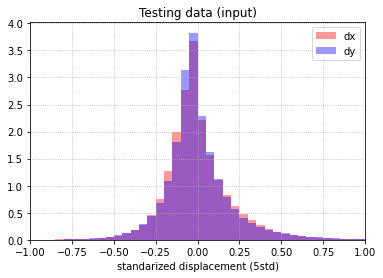

In [17]:
a=in_u10_test.flatten(); b=in_v10_test.flatten()
plt.hist((a-np.nanmean(a))/(5*np.nanstd(a)), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='red', label=f'dx');
plt.hist((b-np.nanmean(b))/(5*np.nanstd(b)), bins=np.arange(-2,2.05,0.05), alpha=0.4, density=True, color='blue', label=f'dy');
plt.xlim(-1,1); plt.legend(); plt.grid(ls=":")
plt.title("Testing data (input)");plt.xlabel("standarized displacement (5std)");
del a,b

In [18]:
def standarization(var,fac=3):
    mean=np.nanmean(var)
    std=np.nanstd(var)*fac #using 3 times std (seems to works better than just 1std)
    var[np.isnan(var)]=0. #fill with 0 in case of nan. This is modifing our input array
    return ((var-mean)/std),mean,std #.astype('float32')

def destandarization(var,mean,std):
    return (var*std+mean) #.astype('float32')

In [19]:
#standarization of data---
std_fac=5 #standarize using "std_fac" times the standard deviation

#training---
#inputs
in_u10_train, in_u10_mean_train, in_u10_std_train = standarization(in_u10_train,std_fac)
in_v10_train, in_v10_mean_train, in_v10_std_train = standarization(in_v10_train,std_fac)
#outputs
out_dx_train, out_dx_mean_train, out_dx_std_train = standarization(out_dx_train,std_fac)
out_dy_train, out_dy_mean_train, out_dy_std_train = standarization(out_dy_train,std_fac)
print("train info:")
print(f"steps={nt_train}; (ny,nx)=({ny},{nx})")
print("input approx output")
print(f"dx_mean, dx_std*{std_fac}, dy_mean, dy_std*{std_fac}:")
print(in_u10_mean_train, in_u10_std_train, in_v10_mean_train, in_v10_std_train)
print()

#testing---
#inputs
in_u10_test, in_u10_mean_test, in_u10_std_test = standarization(in_u10_test,std_fac)
in_v10_test, in_v10_mean_test, in_v10_std_test = standarization(in_v10_test,std_fac)
#outputs
out_dx_test, out_dx_mean_test, out_dx_std_test = standarization(out_dx_test,std_fac)
out_dy_test, out_dy_mean_test, out_dy_std_test = standarization(out_dy_test,std_fac)
print("test info:")
print(f"steps={nt_test}; (ny,nx)=({ny},{nx})")
print("input approx output")
print(f"dx_mean, dx_std*{std_fac}, dy_mean, dy_std*{std_fac}:")
print(in_u10_mean_test, in_u10_std_test, in_v10_mean_test, in_v10_std_test)

train info:
steps=1823; (ny,nx)=(133,304)
input approx output
dx_mean, dx_std*5, dy_mean, dy_std*5:
0.32084227 14.04157042503357 0.49548092 9.95743453502655

test info:
steps=2705; (ny,nx)=(133,304)
input approx output
dx_mean, dx_std*5, dy_mean, dy_std*5:
0.4606412 15.045644044876099 0.51579964 10.372724533081055


### Initialize model

In [20]:
if run_model:

    #loss functions with and without masking---
    class initialization:
        def __init__(self, masking=False, mask=None):
            self.masking=masking
            self.mask=mask

    class loss_function:

        class mse(initialization):
            #we call this function without using its name
            def __call__(self, predict=torch.zeros(1), target=torch.zeros(1)):
                if self.masking:
                    #masking land points---
                    #
                    #- the masking affect: 
                    #    the value of the total loss (that only includes points inside DWS) and hence the last gradient of the backpropagation
                    #    loss=sum(prediction-output)**2/N; dlos/dpred=2*sum(prediction-output)/N,
                    #    with masking N is smaller because we dont consider land points, so seems that its like increasing the overall lr
                    #- similar effect to masking without using it:
                    #    if we use another custom loss like torch.nn.MSELoss(reduction='sum')
                    #    masking is irrelevant since we dont divide with N
                    #
                    #disregard land points (=0) for the mean, so the loss value will increase
                    #mask_torch: 0=land, 1=ocean
                    #however, because we only have particles inside DWS, mask_torch=0 for the land and all points outside DWS
                    loss_val = torch.mean(((predict-target)[self.mask==1])**2)
                else:
                    #original---
                    loss_val = torch.mean((predict-target)**2)  #=torch.nn.MSELoss()
                #
                return loss_val

        class mse_numpy(initialization):
            #we call this function without using its name
            def __call__(self, predict=np.zeros(1), target=np.zeros(1)):
                if self.masking:
                    #masking land points---
                    #disregard land points (=0) for the mean, so the loss value will increase
                    #probably because land points decrease the loss, the model don't perform so well
                    #mask_torch: 0=land, 1=ocean
                    #however, because we only have particles inside DWS, mask_torch=0 all points except inside it
                    loss_val = np.mean(((predict-target)[self.mask==1])**2)
                else:
                    #original---
                    loss_val = np.mean((predict-target)**2)  #=torch.nn.MSELoss()
                #
                return loss_val


    # initialize our model---
    model = convlstm.ConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # choose loss function
    #loss_fn = torch.nn.MSELoss()
    #loss_fn = loss_function.mse() #for training (the same as above)
    loss_fn = loss_function.mse(masking=True,mask=mask_torch) #for training (masking land points)
    #loss_fn_np = loss_function.mse_numpy() #for testing
    loss_fn_np = loss_function.mse_numpy(masking=True,mask=mask_numpy) #for testing
    # choose optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # check the model / loss function and optimizer
    print(model)
    print(loss_fn.__class__.__name__) #this works for pytorch, but also for our custom class
    #print(loss_fn) #only works for pytorch
    print(optimizer)

### Training and testing

In [21]:
def training(epoch,num_epochs,nt,model):

    predict=[]

    # Clear stored gradient
    model.zero_grad()
    # loop through all timesteps
    for t in range(nt):

        #stack data---
        #
        #old method using torch.autograd.Variable and .view()---
        #
        #data_in=np.stack((in_u10_train[t,...],in_v10_train[t,...]))
        #data_out=np.stack((out_dx_train[t,...],out_dy_train[t,...]))
        #data_in = torch.autograd.Variable(torch.Tensor(data_in).view(-1,input_channels,ny,nx)).to(device)
        #data_out = torch.autograd.Variable(torch.Tensor(data_out).view(-1,input_channels,ny,nx)).to(device)
        #
        #new method using  torch.tensor and np.newaxis (the same results as above)---
        data_in = torch.tensor(np.stack((in_u10_train[t,...],
                                         in_v10_train[t,...]),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)
        data_out = torch.tensor(np.stack((out_dx_train[t,...],
                                          out_dy_train[t,...]),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)

        # Forward process---
        #print(torch.cuda.memory_summary()) #check GPU memory usage
        predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  pred_y=(1,output_channels,ny,nx)
        #del data_in; torch.cuda.empty_cache() #to delete this variable from GPU memory

        # compute loss (and the cumulative loss from all the time steps)---
        if t == 0:
            loss0 = loss_fn(predict0, data_out) #data_out=(1,output_channels,ny,nx)
            mae0 = np.mean(abs(predict0-data_out).detach().cpu().numpy())
            #mape0=np.mean( abs((predict0-data_out)/data_out).detach().numpy() ) #problems with mape if denominator = 0
        else:
            loss0 += loss_fn(predict0, data_out)
            mae0 += np.mean(abs(predict0-data_out).detach().cpu().numpy())
            #mape0 += np.mean( abs((predict0-data_out)/data_out).detach().numpy() )
        #del data_out; torch.cuda.empty_cache()

    #cumulative loss from all the time steps (the loss we use for backward propagation)---
    if epoch % 50 == 0: print("Train epoch ", epoch, "; mean(MSE(t)) = ", loss0.item()/nt*std_fac**2, "; mean(MAE(t)) = ", mae0/nt*std_fac)

    # Zero out gradient, else they will accumulate between epochs---
    optimizer.zero_grad()

    # Backward pass---
    # Backward propagation is kicked off when we call .backward() on the error tensor
    # Autograd then calculates and stores the gradients for each model parameter in the parameter’s ".grad" attribute.
    loss0.backward()

    # Update parameters---
    optimizer.step() #to initiate gradient descent

    # Clear stored gradient---
    model.zero_grad()

    # save lr
    lr0=optimizer.param_groups[0]["lr"]

    #predict train data for the last epoch, after updating model parameters
    if epoch == num_epochs-1:
        with torch.no_grad():
            for t in range(nt):
                data_in = torch.from_numpy(np.stack((in_u10_train[t,...],
                                                     in_v10_train[t,...]),axis=0)[np.newaxis,...]).to(device)  #(1,input_channels,ny,nx)
                predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  predict=(1,output_channels,ny,nx)
                predict0 = predict0.detach().cpu().numpy()
                predict.append(predict0) #save the predictions for the last epoch
            predict=np.reshape(predict,(nt,output_channels,ny,nx)) #save to numpy array outputs (nt,output_channels,ny,nx)

    #print(optimizer.param_groups[0]['lr'])
    #
    # save the general checkpoint
    # torch.save({
    #             'epoch': epoch,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': loss0.item()
    #             }, os.path.join(output_path,'Lagrangian_ML_training_checkpoint.pt'))
    # print("The checkpoint of the model and training status is saved.")

    return loss0.item()*1., mae0*1., predict, model, lr0


def testing(epoch,num_epochs,nt,model):
    #this function avoid gradient storage (there is memory increase with time in spite setting requires_grad=False)
    #https://discuss.pytorch.org/t/requires-grad-or-no-grad-in-prediction-phase/35759/2
    with torch.no_grad():

        predict=[]
        # loop through all timesteps
        for t in range(nt):

            # Forward process---
            #by default torch tensor: requires_grad=False---
            data_in = torch.tensor(np.stack((in_u10_test[t,...],
                                             in_v10_test[t,...]),axis=0)[np.newaxis,...],requires_grad=False).to(device)  #(1,input_channels,ny,nx)
            #
            predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  pred_y=(1,output_channels,ny,nx)
            predict0 = predict0.detach().cpu().numpy()

            # Compute loss (and the cumulative loss from all the time steps)---
            data_out = np.stack((out_dx_test[t,...],
                                 out_dy_test[t,...]),axis=0)[np.newaxis,...]  #(1,input_channels,ny,nx)
            if t == 0:
                #loss0 = np.mean((predict0-data_out)**2)
                loss0 = loss_fn_np(predict0, data_out) #MSE numpy loss with mask on land points
                mae0 = np.mean(abs(predict0-data_out))
                #mape0=np.mean( abs((predict-data_out)/data_out).detach().numpy() ) #problems with mape if denominator = 0
            else:
                #loss0 += np.mean((predict0-data_out)**2)
                loss0 += loss_fn_np(predict0, data_out) #MSE numpy loss with mask on land points
                mae0 += np.mean(abs(predict0-data_out))

        if epoch % 50 == 0: print("Test epoch ", epoch, "; mean(MSE(t)) = ", loss0/nt*std_fac**2, "; mean(MAE(t)) = ", mae0/nt*std_fac)

        #predict test data for the last epoch
        if epoch == num_epochs-1:
            for t in range(nt):
                data_in = torch.tensor(np.stack((in_u10_test[t,...],
                                                 in_v10_test[t,...]),axis=0)[np.newaxis,...],requires_grad=False).to(device)  #(1,input_channels,ny,nx)
                predict0, _ = model(data_in, t) #data_in=(1,input_channels,ny,nx)  predict=(1,output_channels,ny,nx)
                predict0 = predict0.detach().cpu().numpy()
                predict.append(predict0) #save the predictions for the last epoch
            predict=np.reshape(predict,(nt,output_channels,ny,nx)) #save to numpy array outputs (nt,output_channels,ny,nx)

        return loss0*1., mae0*1., predict

In [22]:
#run simulation----
if run_model:

    #training output data
    lr = np.zeros(num_epochs)
    loss_train = np.zeros(num_epochs) # save for every epoch the sum of loss for all the time steps for training data
    mae_train = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute error
    #problems with mape if denominator = 0
    #mape = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute percentage error

    #testing output data
    loss_test = np.zeros(num_epochs) # save for every epoch the sum of loss for all the time steps for training data
    mae_test = np.zeros(num_epochs) #save for every epoch the sum of the mean absolute error

    #check memory usage of GPU with
    # torch.cuda.memory_reserved()/1e9 #GB  (this is the important one)
    # torch.cuda.memory_allocated()/1e6 #MB
    # print(torch.cuda.memory_summary()) #More info

    #adaptive learning rate
    if adaptive_learning:
        #lrend = lrini*gamma^(epochs-1)
        #gamma = (lrend/lrini)^(1/(epochs-1))
        gamma=(learning_rate_end/learning_rate)**(1/(num_epochs-1))
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

    #epochs
    for epoch in tqdm(range(num_epochs)):
        #training
        loss_train[epoch], mae_train[epoch], predict_train, model, lr[epoch] = training(epoch,num_epochs,nt_train,model)
        #testing
        loss_test[epoch], mae_test[epoch], predict_test = testing(epoch,num_epochs,nt_test,model)
        #adaptive lr
        if adaptive_learning: scheduler.step()

In [23]:
#save above data---    
def save_data(case,time,loss,mae,pred,dir_out_nc,file_out_nc,lr=None):

    dsout = xr.Dataset()
    #global coords and attrs---
    dsout.coords["time"] = time
    dsout["time"].attrs['description'] = f'times every m2'
    dsout.coords["y"] = dsdis_train.y
    dsout["y"].attrs['description'] = 'y-position in meter'
    dsout.coords["x"] = dsdis_train.x
    dsout["x"].attrs['description'] = 'x-position in meter'
    dsout.coords["out_channels"] = np.arange(output_channels)
    dsout.coords["epoch"] = np.arange(num_epochs)
    #
    dsout.attrs["info"] = f"Data created after {case}"
    #
    #variables---
    #
    dsout["predict"] = (("time","out_channels","y","x"),pred)
    dsout["predict"].attrs['long_name'] = 'Standarized prediction for the last epoch'
    dsout["predict"].attrs['units'] = ""
    #
    dsout["loss"] = (("epoch"),loss)
    dsout["loss"].attrs['long_name'] = 'Loss = MSE from standarized prediction'
    #
    dsout["mae"] = (("epoch"),mae)
    dsout["mae"].attrs['long_name'] = 'Mean Absolute error = MAE from standarized prediction'
    #
    if case=="training":
        dsout["lr"] = (("epoch"),lr)
        dsout["lr"].attrs['long_name'] = 'Learning rate'
    #
    dsout.to_netcdf(dir_out_nc+file_out_nc)
    dsout.close(); del dsout
#
if run_model:
    #train
    save_data(case_train,times_train,loss_train,mae_train,predict_train,dir_convlstm_model_out,file_out_train,lr)
    #test
    save_data(case_test,times_test,loss_test,mae_test,predict_test,dir_convlstm_model_out,file_out_test)

In [5]:
#open data---
dsout_train=xr.open_dataset(dir_convlstm_model_out+file_out_train)
dsout_test=xr.open_dataset(dir_convlstm_model_out+file_out_test)
#
loss_train=dsout_train.loss.values; mae_train=dsout_train.mae.values; predict_train=dsout_train.predict.values
loss_test=dsout_test.loss.values; mae_test=dsout_test.mae.values; predict_test=dsout_test.predict.values

In [41]:
#if we forgot to mask mae during simulation, we can at least try to just multiply by this correction factor, approx 3
#however because we forgot we are adding also mismatches on land points (but this is just a small efect)
#fac_mae=mask_numpy.size/((mask_numpy==1).sum())

### Check results for standarized variables

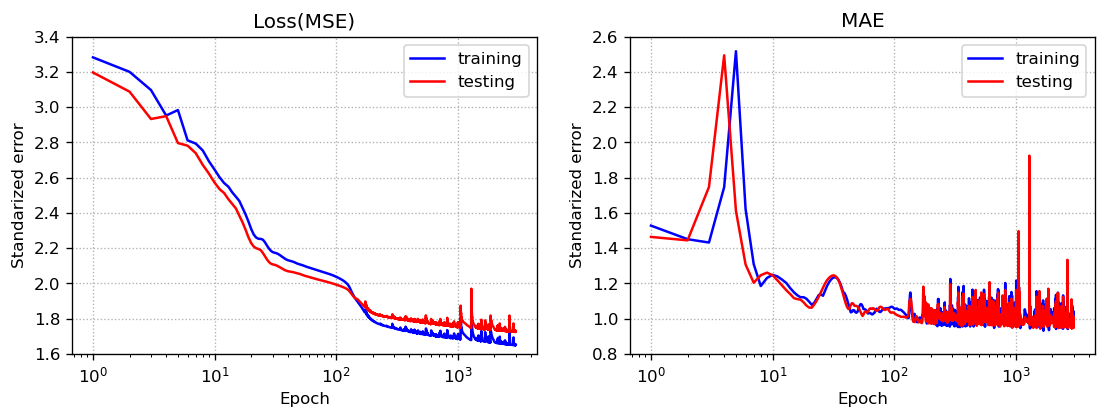

In [29]:
#spatial-temporal avg error for each epoch---
#the loss(MSE) and MAE are from the standarized variables
#for back-propagation we only used the loss(MSE)
#so error=1 means that error is close to 1std of the original data, approx: (std(dx)+std(dy))/2 
fig,ax=plt.subplots(1,2,figsize=(11,3.5),dpi=120)
#
ax[0].semilogx(epochs,loss_train/nt_train*std_fac**2,'b',label='training') #because it was (standarized*3)^2
ax[0].semilogx(epochs,loss_test/nt_test*std_fac**2,'r',label='testing') #because it was (standarized*3)^2
ax[0].set_xlabel('Epoch');ax[0].set_ylabel('Standarized error');ax[0].set_title("Loss(MSE)")
#ax[0].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
ax[0].set_ylim(1.6,3.4); ax[0].grid(ls=":");ax[0].legend()
#
#spatial-temporal avg MAE for each epoch
ax[1].semilogx(epochs,mae_train/nt_train*std_fac,'b',label='training')  #because it was standarized*3
ax[1].semilogx(epochs,mae_test/nt_test*std_fac,'r',label='testing')  #because it was standarized*3
ax[1].set_xlabel('Epoch');ax[1].set_ylabel('Standarized error');ax[1].set_title("MAE")
#ax[1].set_ylabel('$\sum_t$ mae[epoch,t] / N',fontsize=12);
ax[1].set_ylim(0.8,2.6); ax[1].grid(ls=":");ax[1].legend();
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

In [30]:
##check the errors for every time of the last epoch---
#in spite we random init our hidden and cell states, the errors are not huge at the beginning
#however this is because for the first time the displacement was weak
mask_numpy_nan=np.where(mask_numpy==0.,np.nan,1.)
print("standarized errors")
print()
#train---
#data_out=np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1)
mse_train_t=np.nanmean(((predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))**2)*mask_numpy_nan,axis=((1,2,3)))
mae_train_t=np.nanmean(abs(predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))*mask_numpy_nan,axis=((1,2,3)))
print("train")
print("mean(mse(t))=",np.mean(mse_train_t)*std_fac**2)
print("mean(mse(t)) from model=",loss_train[-1]/nt_train*std_fac**2)
#print("mean(mse(t)) using the final output matrix = ",abs((predict_train-data_out)**2).mean()*std_fac**2)
print("mean(mae(t))=",np.mean(mae_train_t)*std_fac)
print("mean(mae(t)) from model=",mae_train[-1]/nt_train*std_fac)
#print("mean(mae(t)) using the final output matrix = ",abs((predict_train-data_out)).mean()*std_fac)
print()

#test---
#data_out=np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1)
mse_test_t=np.nanmean(((predict_test-np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1))**2)*mask_numpy_nan,axis=((1,2,3)))
mae_test_t=np.nanmean(abs(predict_test-np.moveaxis(np.stack((out_dx_test,out_dy_test),axis=0),0,1))*mask_numpy_nan,axis=((1,2,3)))
print("test")
print("mean(mse(t))=",np.mean(mse_test_t)*std_fac**2)
print("mean(mse(t)) from model=",loss_test[-1]/nt_test*std_fac**2)
#print("mean(mse(t)) using the final output matrix = ",abs((predict_test-data_out)**2).mean()*std_fac**2)
print("mean(mae(t))=",np.mean(mae_test_t)*std_fac)
print("mean(mae(t)) from model=",mae_test[-1]/nt_test*std_fac)
#print("mean(mae(t)) using the final output matrix = ",abs((predict_test-data_out)).mean()*std_fac)
print()

standarized errors

train
mean(mse(t))= 1.6488457370224954
mean(mse(t)) from model= 1.649494767515985
mean(mae(t))= 0.8676401093637743
mean(mae(t)) from model= 0.991262121525066

test
mean(mse(t))= 1.7242825705516152
mean(mse(t)) from model= 1.7244163414466842
mean(mae(t))= 0.8820396533757685
mean(mae(t)) from model= 0.9784055815195987



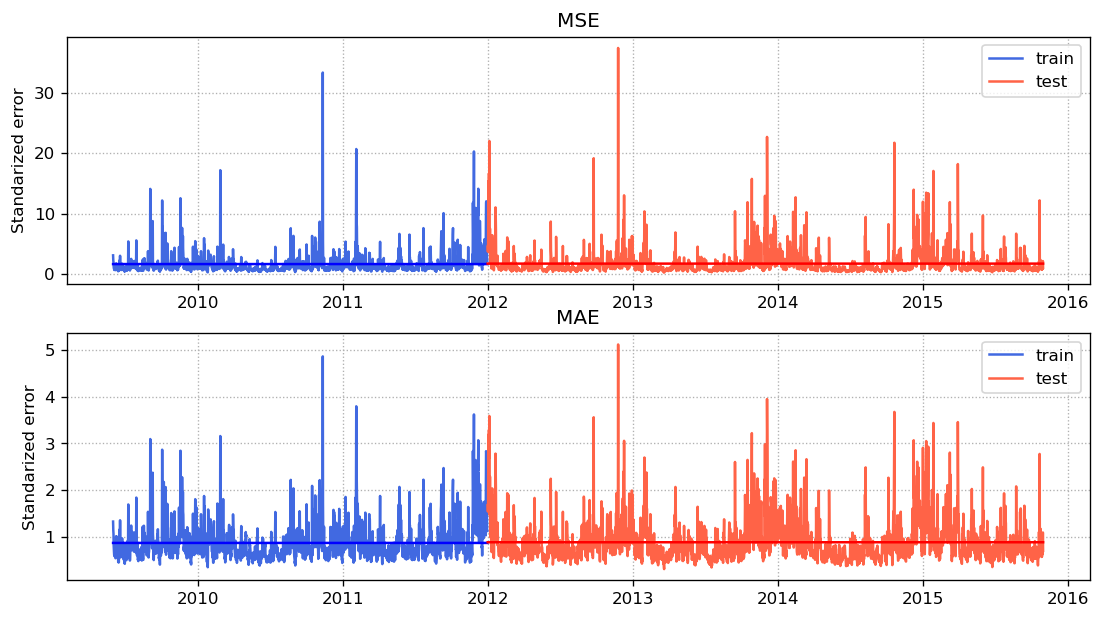

In [42]:
#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(11,6),dpi=120)
#
ax[0].plot(times_train,mse_train_t*std_fac**2,'royalblue',label='train') #because it was (standarized*3)^2
ax[0].plot(times_test,mse_test_t*std_fac**2,'tomato',label='test') #because it was (standarized*3)^2
ax[0].plot(times_train,mse_train_t.mean()*np.ones(times_train.size)*std_fac**2,'-b')
ax[0].plot(times_test,mse_test_t.mean()*np.ones(times_test.size)*std_fac**2,'-r')
ax[0].set_ylabel('Standarized error');ax[0].set_title("MSE")
#ax[0].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
ax[0].grid(ls=":");ax[0].legend()
#
#spatial-temporal avg MAE for each epoch
ax[1].plot(times_train,mae_train_t*std_fac,'royalblue',label='train') #because it was (standarized*3)^2
ax[1].plot(times_test,mae_test_t*std_fac,'tomato',label='test') #because it was (standarized*3)^2
ax[1].plot(times_train,mae_train_t.mean()*np.ones(times_train.size)*std_fac,'-b')
ax[1].plot(times_test,mae_test_t.mean()*np.ones(times_test.size)*std_fac,'-r')
ax[1].set_ylabel('Standarized error');ax[1].set_title("MAE")
#ax[1].set_ylabel('$\sum_t$ loss[epoch,t] / N',fontsize=12)
ax[1].grid(ls=":");ax[1].legend();
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

/tmp/ipykernel_107391/3496445425.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall
/tmp/ipykernel_107391/3496445425.py:12: UserWarning: No contour levels were found within the data range.
  ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
/tmp/ipykernel_107391/3496445425.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or s

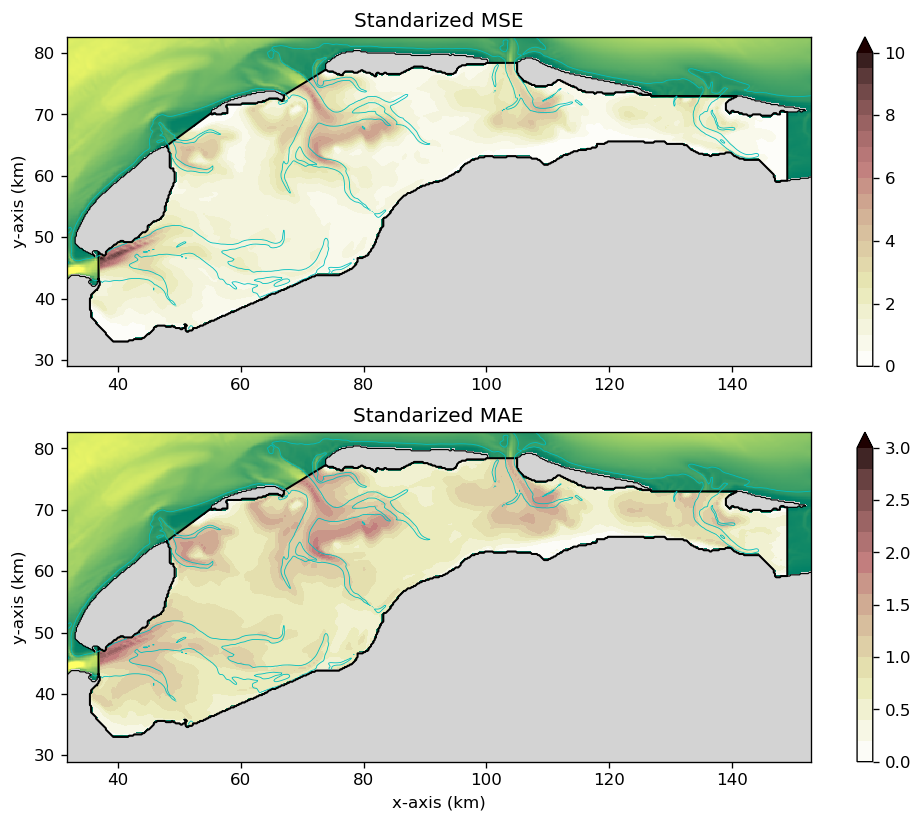

In [46]:
#spatial standarized errors---
mse_train_xy=(((predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1))**2).mean(axis=(0,1))*std_fac**2)*mask #to pun NaN again on land
mae_train_xy=(abs(predict_train-np.moveaxis(np.stack((out_dx_train,out_dy_train),axis=0),0,1)).mean(axis=(0,1))*std_fac)*mask #to pun NaN again on land

fig,ax=plt.subplots(2,1,figsize=(10,8),dpi=120)
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#MSE
val = np.ma.array(mse_train_xy, mask=np.isnan(mse_train_xy)) #mask because array has nan values
cs=ax[0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0].contourf(xx,yy,val,levels=np.arange(0,10.5,.5),cmap='pink_r',extend='max');plt.colorbar(cs,ax=ax[0],ticks=np.arange(0,12,2))
ax[0].axis("equal"); ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0].set_title("Standarized MSE")
ax[0].set_ylabel("y-axis (km)");#ax[0].set_xlabel("x-axis (km)");
#MAE
val = np.ma.array(mae_train_xy, mask=np.isnan(mae_train_xy)) #mask because array has nan values
cs=ax[1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,3.2,.2),cmap='pink_r',extend='max');plt.colorbar(cs,ax=ax[1],ticks=np.arange(0,3.5,.5))
ax[1].axis("equal"); ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[1].set_title("Standarized MAE")
ax[1].set_xlabel("x-axis (km)");ax[1].set_ylabel("y-axis (km)");
#fig.savefig('figures/loss_mae.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

### Check results for variables with dimensions

In [47]:
#recover original units---

#multiply by mask to recover nan values on land (only for output and prediction data)

#training---
#input
in_u10_train = destandarization(in_u10_train, in_u10_mean_train, in_u10_std_train)
in_v10_train = destandarization(in_v10_train, in_v10_mean_train, in_v10_std_train)
#output
out_dx_train = destandarization(out_dx_train, out_dx_mean_train, out_dx_std_train)*mask
out_dy_train = destandarization(out_dy_train, out_dy_mean_train, out_dy_std_train)*mask
#prediction
pred_dx_train = destandarization(predict_train[:,0,...], out_dx_mean_train, out_dx_std_train)*mask
pred_dy_train = destandarization(predict_train[:,1,...], out_dy_mean_train, out_dy_std_train)*mask
print("training statistics")
print("real data")
print(np.nanmin(out_dx_train),np.nanmean(out_dx_train),np.nanmax(out_dx_train), np.nanmin(out_dy_train),np.nanmean(out_dy_train),np.nanmax(out_dy_train))
print("predictions")
print(np.nanmin(pred_dx_train),np.nanmean(pred_dx_train),np.nanmax(pred_dx_train), np.nanmin(pred_dy_train),np.nanmean(pred_dy_train),np.nanmax(pred_dy_train))
print()

#testing---
#input
in_u10_test = destandarization(in_u10_test, in_u10_mean_test, in_u10_std_test)
in_v10_test = destandarization(in_v10_test, in_v10_mean_test, in_v10_std_test)
#output
out_dx_test = destandarization(out_dx_test, out_dx_mean_test, out_dx_std_test)*mask
out_dy_test = destandarization(out_dy_test, out_dy_mean_test, out_dy_std_test)*mask
#prediction
pred_dx_test = destandarization(predict_test[:,0,...], out_dx_mean_test, out_dx_std_test)*mask
pred_dy_test = destandarization(predict_test[:,1,...], out_dy_mean_test, out_dy_std_test)*mask
print("testing statistics")
print("real data")
print(np.nanmin(out_dx_test),np.nanmean(out_dx_test),np.nanmax(out_dx_test), np.nanmin(out_dy_test),np.nanmean(out_dy_test),np.nanmax(out_dy_test))
print("predictions")
print(np.nanmin(pred_dx_test),np.nanmean(pred_dx_test),np.nanmax(pred_dx_test), np.nanmin(pred_dy_test),np.nanmean(pred_dy_test),np.nanmax(pred_dy_test))

training statistics
real data
-24.748878 0.32180932 24.240934 -13.619102 0.49631402 22.307367
predictions
-7.485542 0.34249654 7.9937944 -5.0764446 0.47952354 5.916913

testing statistics
real data
-27.577902 0.4599705 26.997688 -13.733101 0.51538575 20.565374
predictions
-7.7318945 0.4132452 8.664521 -5.0767064 0.5087485 6.1615562


In [48]:
##check the errors for every time of the last epoch---
#in spite we random init our hidden and cell states, the errors are not huge at the beginning
#however this is because for the first time the displacement was weak

#train---
rmse_dx_train_t=np.nanmean((pred_dx_train-out_dx_train)**2,axis=((1,2)))**.5
rmse_dy_train_t=np.nanmean((pred_dy_train-out_dy_train)**2,axis=((1,2)))**.5
mae_dx_train_t=np.nanmean(abs(pred_dx_train-out_dx_train),axis=((1,2)))
mae_dy_train_t=np.nanmean(abs(pred_dy_train-out_dy_train),axis=((1,2)))
print("train")
print(f"mean(rmse_dx(t)), mean(rmse_dy(t)) = {np.nanmean(rmse_dx_train_t):.2f}km, {np.nanmean(rmse_dy_train_t):.2f}km")
print(f"mean(mae_dx(t)), mean(mae_dy(t)) = {np.nanmean(mae_dx_train_t):.2f}km, {np.nanmean(mae_dy_train_t):.2f}km")
print()

#test---
rmse_dx_test_t=np.nanmean((pred_dx_test-out_dx_test)**2,axis=((1,2)))**.5
rmse_dy_test_t=np.nanmean((pred_dy_test-out_dy_test)**2,axis=((1,2)))**.5
mae_dx_test_t=np.nanmean(abs(pred_dx_test-out_dx_test),axis=((1,2)))
mae_dy_test_t=np.nanmean(abs(pred_dy_test-out_dy_test),axis=((1,2)))
print("test")
print(f"mean(rmse_dx(t)), mean(rmse_dy(t)) = {np.nanmean(rmse_dx_test_t):.2f}km, {np.nanmean(rmse_dy_test_t):.2f}km")
print(f"mean(mae_dx(t)), mean(mae_dy(t)) = {np.nanmean(mae_dx_test_t):.2f}km, {np.nanmean(mae_dy_test_t):.2f}km")
print()

train
mean(rmse_dx(t)), mean(rmse_dy(t)) = 1.92km, 1.35km
mean(mae_dx(t)), mean(mae_dy(t)) = 1.44km, 0.96km

test
mean(rmse_dx(t)), mean(rmse_dy(t)) = 2.06km, 1.43km
mean(mae_dx(t)), mean(mae_dy(t)) = 1.55km, 1.03km



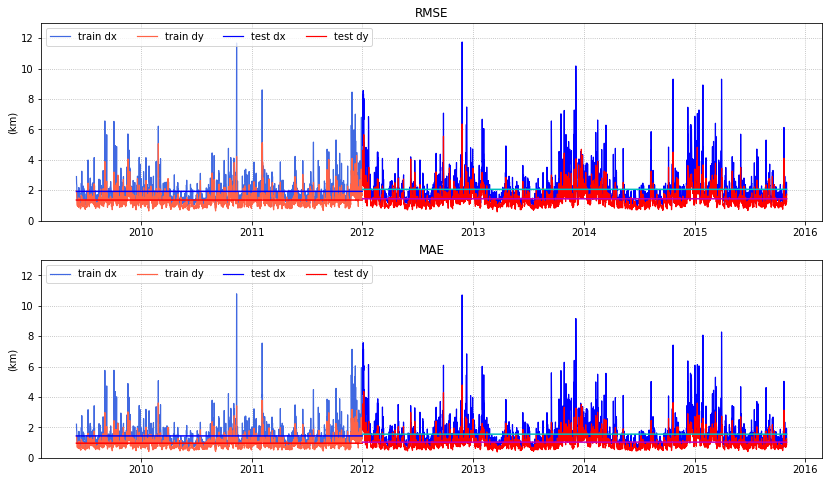

In [49]:
#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(14,8))
#
maxval=np.max((np.ceil(abs(np.concatenate((rmse_dx_train_t,rmse_dy_train_t,rmse_dx_test_t,rmse_dy_test_t))).max()),
               np.ceil(abs(np.concatenate((mae_dx_train_t,mae_dy_train_t,mae_dx_test_t,mae_dy_test_t))).max()) ))+1
#
#MSE
#train
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t.mean()*np.ones(times_train.size),ls='-',c='b')
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t.mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t.mean()*np.ones(times_test.size),ls='-',c='c')
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t.mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[0].set_ylim(0,maxval)
ax[0].set_ylabel('(km)');ax[0].set_title("RMSE")
ax[0].grid(ls=":");ax[0].legend(ncol=4,loc="upper left")
#
#MAE
#train
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t.mean()*np.ones(times_train.size),ls='-',c='b')
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t.mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t.mean()*np.ones(times_test.size),ls='-',c='c')
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t.mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[1].set_ylim(0,maxval)
ax[1].set_ylabel('(km)');ax[1].set_title("MAE")
ax[1].grid(ls=":");ax[1].legend(ncol=4,loc="upper left");

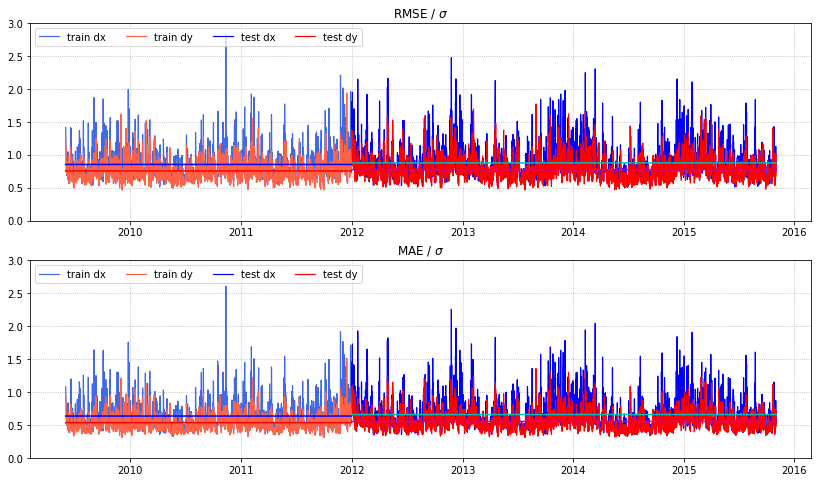

In [50]:
#the same as above but for the normalized errors (with std of output)
#
std_out_dx_train_t=np.nanstd(out_dx_train,axis=((1,2)))
std_out_dy_train_t=np.nanstd(out_dy_train,axis=((1,2)))
std_out_dx_test_t=np.nanstd(out_dx_test,axis=((1,2)))
std_out_dy_test_t=np.nanstd(out_dy_test,axis=((1,2)))
#

#MSE and MAE as a function of time for the last epoch---
fig,ax=plt.subplots(2,1,figsize=(14,8))
#
maxval=np.max((np.ceil(abs(np.concatenate((rmse_dx_train_t/std_out_dx_train_t,rmse_dy_train_t/std_out_dy_train_t,rmse_dx_test_t/std_out_dx_test_t,rmse_dy_test_t/std_out_dy_test_t))).max()),
               np.ceil(abs(np.concatenate((mae_dx_train_t/std_out_dx_train_t,mae_dy_train_t/std_out_dy_train_t,mae_dx_test_t/std_out_dx_test_t,mae_dy_test_t/std_out_dy_test_t))).max()) ))#+1
#
#MSE
#train
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dx_train_t/std_out_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),rmse_dy_train_t/std_out_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[0].plot(times_train+np.timedelta64(m2,'s'),(rmse_dx_train_t/std_out_dx_train_t).mean()*np.ones(times_train.size),ls='-',c='b')
ax[0].plot(times_train+np.timedelta64(m2,'s'),(rmse_dy_train_t/std_out_dy_train_t).mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dx_test_t/std_out_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),rmse_dy_test_t/std_out_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[0].plot(times_test+np.timedelta64(m2,'s'),(rmse_dx_test_t/std_out_dx_test_t).mean()*np.ones(times_test.size),ls='-',c='c')
ax[0].plot(times_test+np.timedelta64(m2,'s'),(rmse_dy_test_t/std_out_dy_test_t).mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[0].set_ylim(0,maxval)
ax[0].set_title(f"RMSE / $\sigma$"); ax[0].grid(ls=":");ax[0].legend(ncol=4,loc="upper left");
#
#MAE
#train
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dx_train_t/std_out_dx_train_t,c='royalblue',ls='-',label='train dx',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),mae_dy_train_t/std_out_dy_train_t,c='tomato',ls='-',label='train dy',lw=1.2)
ax[1].plot(times_train+np.timedelta64(m2,'s'),(mae_dx_train_t/std_out_dx_train_t).mean()*np.ones(times_train.size),ls='-',c='b')
ax[1].plot(times_train+np.timedelta64(m2,'s'),(mae_dy_train_t/std_out_dy_train_t).mean()*np.ones(times_train.size),ls='-',c='r')
#test
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dx_test_t/std_out_dx_test_t,c='b',ls='-',label='test dx',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),mae_dy_test_t/std_out_dy_test_t,c='r',ls='-',label='test dy',lw=1.2)
ax[1].plot(times_test+np.timedelta64(m2,'s'),(mae_dx_test_t/std_out_dx_test_t).mean()*np.ones(times_test.size),ls='-',c='c')
ax[1].plot(times_test+np.timedelta64(m2,'s'),(mae_dy_test_t/std_out_dy_test_t).mean()*np.ones(times_test.size),ls='-',c='m')
#
ax[1].set_ylim(0,maxval)
ax[1].set_title(f"MAE / $\sigma$"); ax[1].grid(ls=":");ax[1].legend(ncol=4,loc="upper left");

In [61]:
#amount of data in below figure:
print(f"amount of output/predict train data = out_channels*nx*ny*nt = {output_channels*out_dx_train.size}")
print(f"amount of output/predict test data = out_channels*nx*ny*nt = {output_channels*out_dx_test.size}")

amount of output/predict train data = out_channels*nx*ny*nt = 147415072
amount of output/predict test data = out_channels*nx*ny*nt = 218737120


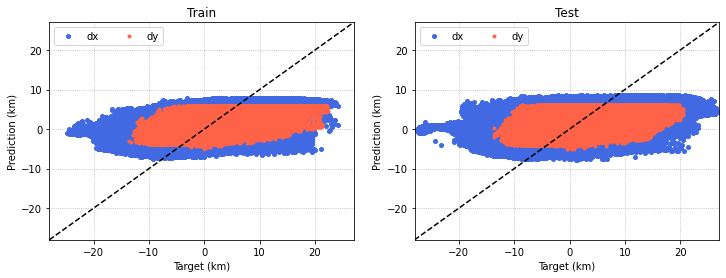

In [64]:
#take too much time when using several years---

fig,ax=plt.subplots(1,2,figsize=(12,4))
#
minval=np.min((np.floor(np.array((np.nanmin(out_dx_train),np.nanmin(pred_dx_train),np.nanmin(out_dy_train),np.nanmin(pred_dy_train))).min()),
               np.floor(np.array((np.nanmin(out_dx_test),np.nanmin(pred_dx_test),np.nanmin(out_dy_test),np.nanmin(pred_dy_test))).min()) ))
maxval=np.max((np.ceil(np.array((np.nanmax(out_dx_train),np.nanmax(pred_dx_train),np.nanmax(out_dy_train),np.nanmax(pred_dy_train))).max()),
               np.ceil(np.array((np.nanmax(out_dx_test),np.nanmax(pred_dx_test),np.nanmax(out_dy_test),np.nanmax(pred_dy_test))).max()) ))
#train
ax[0].plot(out_dx_train.flatten(),pred_dx_train.flatten(),'o',c="royalblue",ms=4,label='dx')
ax[0].plot(out_dy_train.flatten(),pred_dy_train.flatten(),'o',c="tomato",ms=3,label='dy')
ax[0].plot(np.linspace(minval,maxval,100),np.linspace(minval,maxval,100),'--k')
ax[0].set_xlabel('Target (km)');ax[0].set_ylabel('Prediction (km)');ax[0].set_title("Train")
ax[0].grid(ls=":");ax[0].legend(ncol=2,loc="upper left")
ax[0].axis([minval,maxval,minval,maxval]);
#test
ax[1].plot(out_dx_test.flatten(),pred_dx_test.flatten(),'o',c="royalblue",ms=4,label='dx')
ax[1].plot(out_dy_test.flatten(),pred_dy_test.flatten(),'o',c="tomato",ms=3,label='dy')
ax[1].plot(np.linspace(minval,maxval,100),np.linspace(minval,maxval,100),'--k')
ax[1].set_xlabel('Target (km)');ax[1].set_ylabel('Prediction (km)');ax[1].set_title("Test")
ax[1].grid(ls=":");ax[1].legend(ncol=2,loc="upper left")
ax[1].axis([minval,maxval,minval,maxval]);

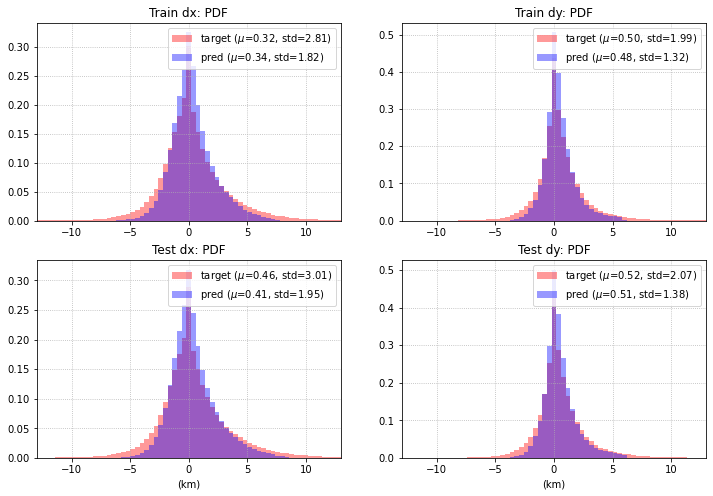

In [63]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
#train dx
ax[0,0].hist(out_dx_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dx_train):.2f}, std={np.nanstd(out_dx_train):.2f})');
ax[0,0].hist(pred_dx_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dx_train):.2f}, std={np.nanstd(pred_dx_train):.2f})');
ax[0,0].set_xlim(-13,13); ax[0,0].legend(); ax[0,0].grid(ls=":")
ax[0,0].set_title("Train dx: PDF")
#train dy
ax[0,1].hist(out_dy_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dy_train):.2f}, std={np.nanstd(out_dy_train):.2f})');
ax[0,1].hist(pred_dy_train.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dy_train):.2f}, std={np.nanstd(pred_dy_train):.2f})');
ax[0,1].set_xlim(-13,13); ax[0,1].legend(); ax[0,1].grid(ls=":")
ax[0,1].set_title("Train dy: PDF")
#
#test dx
ax[1,0].hist(out_dx_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dx_test):.2f}, std={np.nanstd(out_dx_test):.2f})');
ax[1,0].hist(pred_dx_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dx_test):.2f}, std={np.nanstd(pred_dx_test):.2f})');
ax[1,0].set_xlim(-13,13); ax[1,0].legend(); ax[1,0].grid(ls=":")
ax[1,0].set_title("Test dx: PDF");ax[1,0].set_xlabel("(km)");
#test dy
ax[1,1].hist(out_dy_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='red', label=f'target ($\mu$={np.nanmean(out_dy_test):.2f}, std={np.nanstd(out_dy_test):.2f})');
ax[1,1].hist(pred_dy_test.flatten(), bins=np.arange(-15,15.4,0.4), alpha=0.4, density=True, color='blue', label=f'pred ($\mu$={np.nanmean(pred_dy_test):.2f}, std={np.nanstd(pred_dy_test):.2f})');
ax[1,1].set_xlim(-13,13); ax[1,1].legend(); ax[1,1].grid(ls=":")
ax[1,1].set_title("Test dy: PDF");ax[1,1].set_xlabel("(km)");

/tmp/ipykernel_101007/1950471163.py:3: RuntimeWarning: Mean of empty slice
  rmse_train_dx_xy=np.nanmean((pred_dx_train-out_dx_train)**2,axis=0)**.5
/tmp/ipykernel_101007/1950471163.py:4: RuntimeWarning: Mean of empty slice
  rmse_train_dy_xy=np.nanmean((pred_dy_train-out_dy_train)**2,axis=0)**.5
/tmp/ipykernel_101007/1950471163.py:5: RuntimeWarning: Mean of empty slice
  rmse_test_dx_xy=np.nanmean((pred_dx_test-out_dx_test)**2,axis=0)**.5
/tmp/ipykernel_101007/1950471163.py:6: RuntimeWarning: Mean of empty slice
  rmse_test_dy_xy=np.nanmean((pred_dy_test-out_dy_test)**2,axis=0)**.5
/tmp/ipykernel_101007/1950471163.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bath

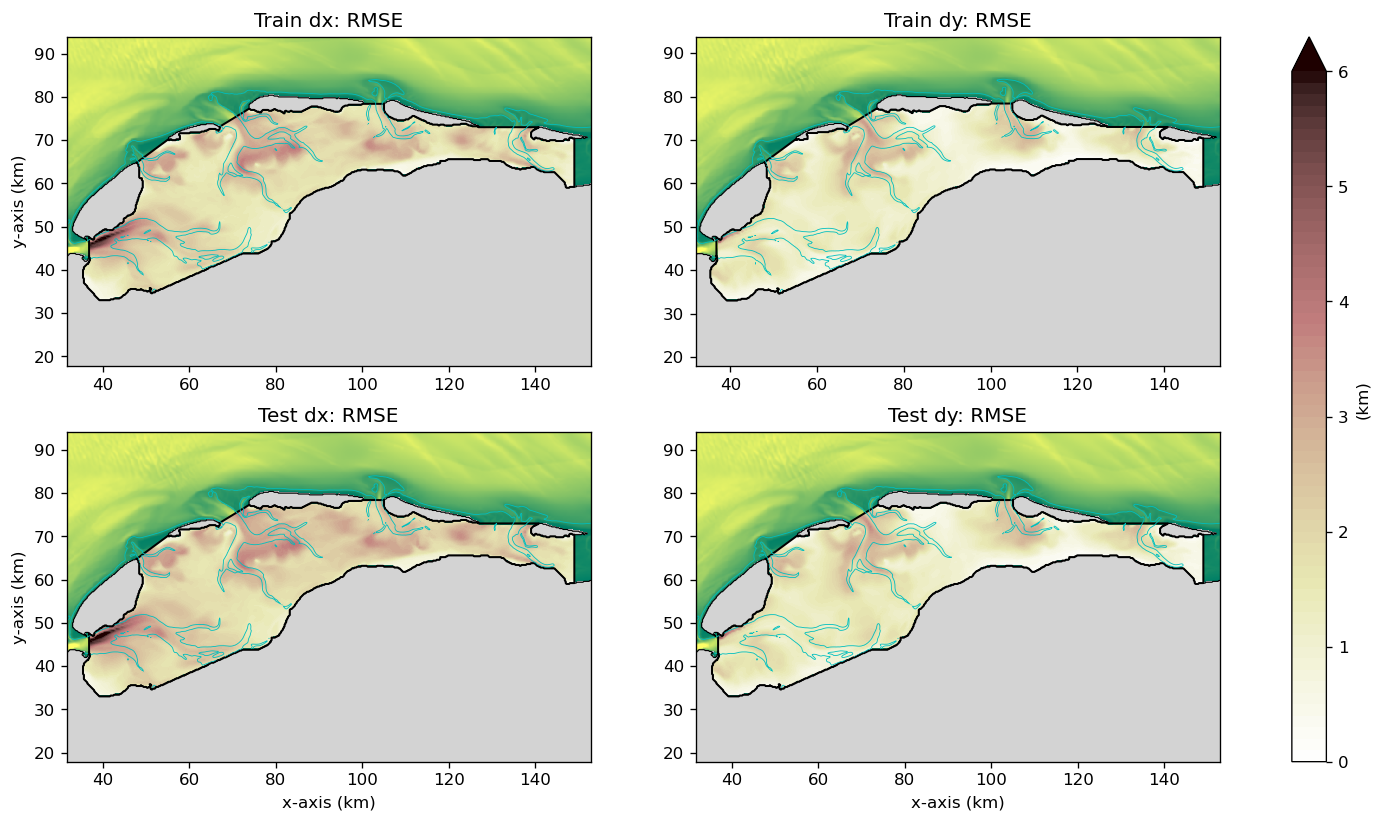

In [65]:
#spatial errors---

rmse_train_dx_xy=np.nanmean((pred_dx_train-out_dx_train)**2,axis=0)**.5
rmse_train_dy_xy=np.nanmean((pred_dy_train-out_dy_train)**2,axis=0)**.5
rmse_test_dx_xy=np.nanmean((pred_dx_test-out_dx_test)**2,axis=0)**.5
rmse_test_dy_xy=np.nanmean((pred_dy_test-out_dy_test)**2,axis=0)**.5

#plot---
fig,ax=plt.subplots(2,2,figsize=(15.5,8),dpi=120)
#
maxval=np.floor(np.array((np.nanmax(rmse_train_dx_xy),np.nanmax(rmse_train_dy_xy),
                          np.nanmax(rmse_test_dx_xy),np.nanmax(rmse_test_dy_xy))).max())
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#
val = np.ma.array(rmse_train_dx_xy, mask=np.isnan(rmse_train_dx_xy)) #mask because array has nan values
cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,0].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[0,0].axis("equal"); ax[0,0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0,0].set_title("Train dx: RMSE")
ax[0,0].set_ylabel("y-axis (km)");#ax[0,0].set_xlabel("x-axis (km)");
#
val = np.ma.array(rmse_train_dy_xy, mask=np.isnan(rmse_train_dy_xy)) #mask because array has nan values
cs=ax[0,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,1].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[0,1].axis("equal"); ax[0,1].axis([xx[0,1],xx[0,-1],yy[0,1],yy[-1,0]])
ax[0,1].set_title("Train dy: RMSE")
#
val = np.ma.array(rmse_test_dx_xy, mask=np.isnan(rmse_test_dx_xy)) #mask because array has nan values
cs=ax[1,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,0].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[1,0].axis("equal"); ax[1,0].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,0].set_title("Test dx: RMSE")
ax[1,0].set_xlabel("x-axis (km)");ax[1,0].set_ylabel("y-axis (km)");
#
val = np.ma.array(rmse_test_dy_xy, mask=np.isnan(rmse_test_dy_xy)) #mask because array has nan values
cs=ax[1,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,1].contourf(xx,yy,val,levels=np.arange(0,maxval+.1,.1),cmap='pink_r',extend='max')
ax[1,1].axis("equal"); ax[1,1].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,1].set_title("Test dy: RMSE")
ax[1,1].set_xlabel("x-axis (km)");
#
fig.colorbar(cs,ax=ax.ravel().tolist(),label="(km)",ticks=np.arange(0,maxval+1,1));
#old method (control size)
#cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#fig.colorbar(cs, cax=cbar_ax,label="(km)",title="RMSE")

/export/lv4/user/jfajardourbina/programs/miniconda3/envs/phd_parcelsv221/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_101007/1082840993.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall
/tmp/ipykernel_101007/1082840993.py:19: UserWarning: No contour levels were found within the data range.
  ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
/tmp/ipykernel_1010

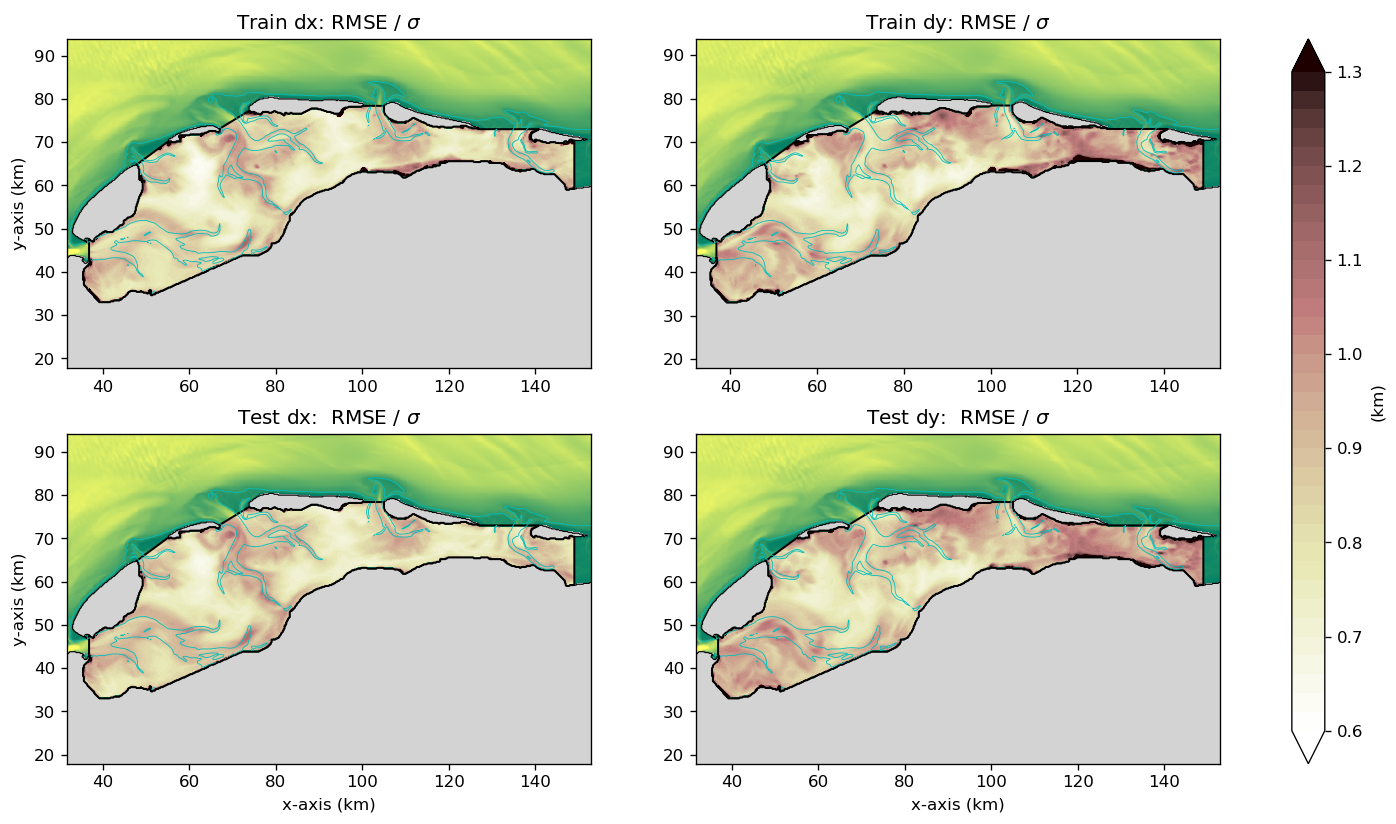

In [66]:
#spatial errors normalized with std---
std_out_dx_train_xy=np.nanstd(out_dx_train,axis=0)
std_out_dy_train_xy=np.nanstd(out_dy_train,axis=0)
std_out_dx_test_xy=np.nanstd(out_dx_test,axis=0)
std_out_dy_test_xy=np.nanstd(out_dy_test,axis=0)

#plot---
fig,ax=plt.subplots(2,2,figsize=(15.5,8),dpi=120)
#
#maxval=np.floor(np.array(((rmse_train_dx_xy/std_out_dx_train_xy).max(),(rmse_train_dy_xy/std_out_dy_train_xy).max(),
#                          (rmse_test_dx_xy/std_out_dx_test_xy).max(),(rmse_test_dy_xy/std_out_dy_test_xy).max())).max())
minval=0.6;maxval=1.3
#
cmap=mpl.cm.get_cmap('summer').copy()
cmap.set_bad(color='lightgray') #nan=gray
#
val = np.ma.array(rmse_train_dx_xy, mask=np.isnan(rmse_train_dx_xy))/std_out_dx_train_xy #mask because array has nan values
cs=ax[0,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,0].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[0,0].axis("equal"); ax[0,0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])
ax[0,0].set_title(f"Train dx: RMSE / $\sigma$")
ax[0,0].set_ylabel("y-axis (km)");#ax[0,0].set_xlabel("x-axis (km)");
#
val = np.ma.array(rmse_train_dy_xy, mask=np.isnan(rmse_train_dy_xy))/std_out_dy_train_xy #mask because array has nan values
cs=ax[0,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[0,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[0,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[0,1].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[0,1].axis("equal"); ax[0,1].axis([xx[0,1],xx[0,-1],yy[0,1],yy[-1,0]])
ax[0,1].set_title(f"Train dy: RMSE / $\sigma$")
#
val = np.ma.array(rmse_test_dx_xy, mask=np.isnan(rmse_test_dx_xy))/std_out_dx_test_xy #mask because array has nan values
cs=ax[1,0].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,0].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,0].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[1,0].axis("equal"); ax[1,0].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,0].set_title(f"Test dx:  RMSE / $\sigma$")
ax[1,0].set_xlabel("x-axis (km)");ax[1,0].set_ylabel("y-axis (km)");
#
val = np.ma.array(rmse_test_dy_xy, mask=np.isnan(rmse_test_dy_xy))/std_out_dy_test_xy #mask because array has nan values
cs=ax[1,1].pcolormesh(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],vmin=-2,vmax=32,cmap=cmap,shading='auto'); #avoid artificial eastern wall 
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,mask_topo[:,:-1],levels=[1],linewidths=.7,colors='k') #avoid artificial eastern wall
ax[1,1].contour(dsto.xc[:-1]/1e3,dsto.yc/1e3,dsto.bathymetry[:,:-1],levels=[5],linewidths=.5,colors='c') 
ax[1,1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,ls='-',color='k',lw=1.2,markersize=0,zorder=1)
cs=ax[1,1].contourf(xx,yy,val,levels=np.arange(minval,maxval+.02,.02),cmap='pink_r',extend='both')
ax[1,1].axis("equal"); ax[1,1].axis([xx[1,0],xx[0,-1],yy[1,0],yy[-1,0]])
ax[1,1].set_title(f"Test dy:  RMSE / $\sigma$")
ax[1,1].set_xlabel("x-axis (km)");
#
fig.colorbar(cs,ax=ax.ravel().tolist(),label="(km)",ticks=np.arange(minval,maxval+.1,.1));
#old method (control size)
#cbar_ax = fig.add_axes([0.93, 0.15, 0.03, 0.7])
#fig.colorbar(cs, cax=cbar_ax,label="(km)",title="RMSE")

In [33]:
### Check training-----

In [67]:
def plotting_train(ii,tt,scale=200,width=0.0038):
    
    fig,ax=plt.subplots(1,3,figsize=(16,3.5),dpi=120)

    iyy=6;ixx=6
        
    #data input at t=t0---
    print(tt)
    #val=(u10_train[ii+1,...]**2+v10_train[ii+1,...]**2)**.5
    val=(in_u10_train[ii,...]**2+in_v10_train[ii,...]**2)**.5
    #plt.contourf(xx,yy,val,cmap='jet');plt.colorbar()
    cs=ax[0].contourf(xx,yy,val*mask,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[0],label='(km)')
    ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[0].axis("equal");
    q=ax[0].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],in_u10_train[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],in_v10_train[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    #ax[0].quiverkey(q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
    ax[0].set_title("predictor (net dis) at T0")
    ax[0].set_xlabel("x-axis (km)");ax[0].set_ylabel("y-axis (km)");

    ##data output at t=t0+M2---
    val=(out_dx_train[ii,...]**2+out_dy_train[ii,...]**2)**.5
    cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[1],label='(km)')
    ax[1].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])#;ax[1].axis("equal"); 
    ax[1].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],out_dx_train[ii,...][::iyy,::ixx],out_dy_train[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[1].set_title("true predictant (net dis) at T0+M2")
    ax[1].set_xlabel("x-axis (km)")

    #prediction at t=t0+M2---
    valp=(pred_dx_train[ii,...]**2+pred_dy_train[ii,...]**2)**.5
    cs=ax[2].contourf(xx,yy,valp,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[2],label='(km)')
    ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[2].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[2].axis("equal")
    ax[2].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],pred_dx_train[ii,...][::iyy,::ixx],pred_dy_train[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[2].set_title("prediction (net dis) at T0+M2")
    ax[2].set_xlabel("x-axis (km)");
    
    fig.colorbar(cs,ax=ax.ravel().tolist(),label='(km)');
    
    #with units---
    print(f"rmse_dx={rmse_dx_train_t[ii]:.2f}km, rmse_dy={rmse_dy_train_t[ii]:.2f}km, sqrt(mse_dx+mse_dy)={(rmse_dx_train_t[ii]**2+rmse_dy_train_t[ii]**2)**.5:.2f}km, rmse_magnitude={np.nanmean((val-valp)**2)**.5:.2f}km")
    #the same as above
    #print(f"rmse_dx={np.mean((out_dx_train[ii,...]-pred_dx_train[ii,...])**2)**.5:.2f}km, rmse_dy={np.mean((out_dy_train[ii,...]-pred_dy_train[ii,...])**2)**.5:.2f}km, sqrt(mse_dx+mse_dy)={np.mean((out_dx_train[ii,...]-pred_dx_train[ii,...])**2+(out_dy_train[ii,...]-pred_dy_train[ii,...])**2)**.5:.2f}km")
    #without units---
    print(f"standarized mse_dx+mse_dy = {mse_train_t[ii]*9:.2f}")
    print()
    #fig.savefig(f'figures/prediction-{tt}.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

In [68]:
# ii=nt_train-70
# tt=str(times_train[ii])[:19].replace(":","-")
# plotting_train(ii,tt)

2009-11-25T15-19-02
rmse_dx=2.05km, rmse_dy=1.59km, sqrt(mse_dx+mse_dy)=2.59km, rmse_magnitude=2.24km
standarized mse_dx+mse_dy = 0.64



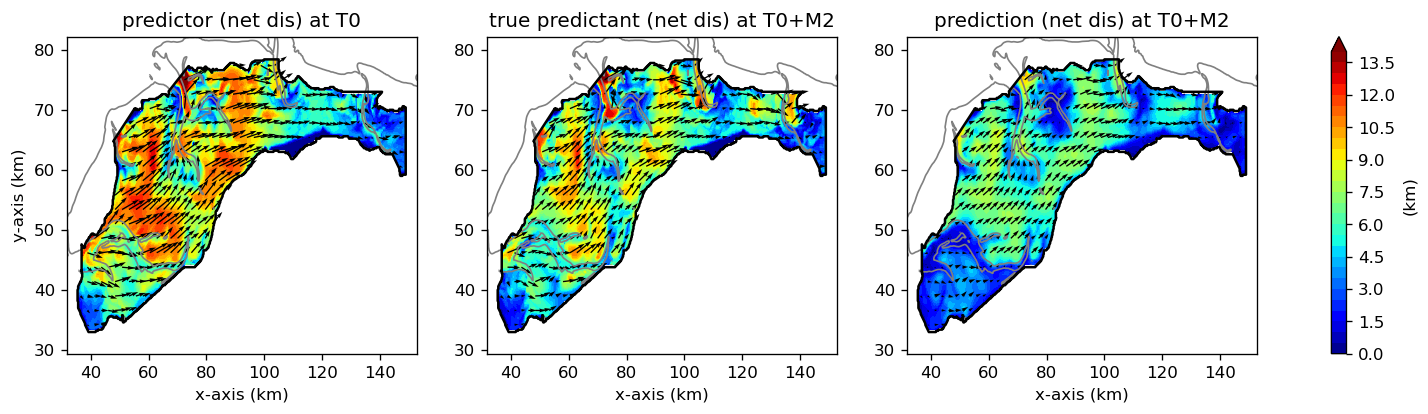

In [69]:
ii=np.nonzero(times_train==np.datetime64("2009-11-25T15:19:02"))[0][0]
tt=str(times_train[ii])[:19].replace(":","-")
plotting_train(ii,tt)

2011-10-22T04-32-38
rmse_dx=1.79km, rmse_dy=1.28km, sqrt(mse_dx+mse_dy)=2.20km, rmse_magnitude=1.77km
standarized mse_dx+mse_dy = 0.45



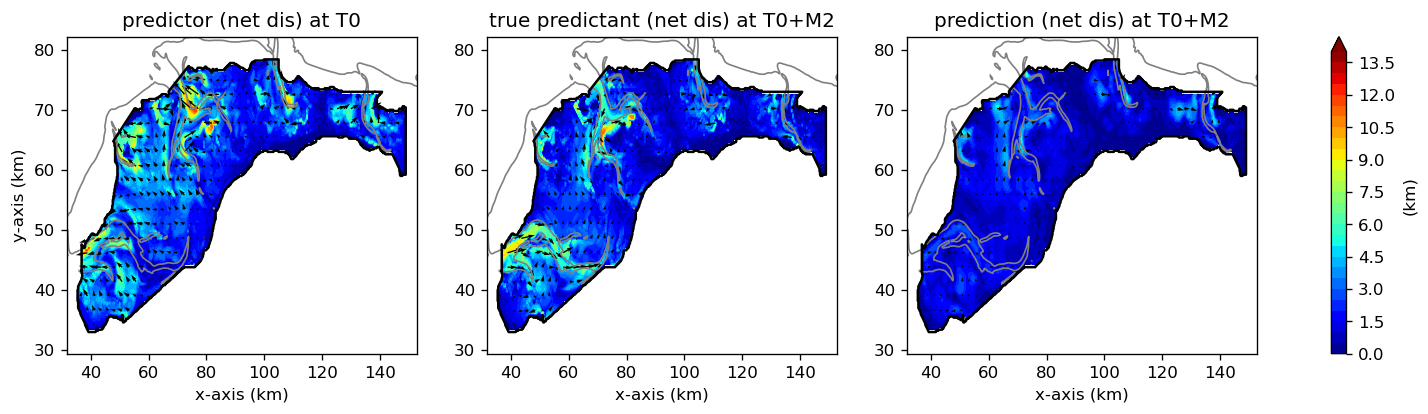

In [70]:
ii=nt_train-136
tt=str(times_train[ii])[:19].replace(":","-")
plotting_train(ii,tt)

In [71]:
### Check testing-----

In [72]:
#check in testing times of min and max error (use the standarized error to find dates)---
ii0=np.nonzero(mse_test_t==mse_test_t.min())[0][0]
print(ii0,mse_test_t[ii0]*9)
ii1=np.nonzero(mse_test_t==mse_test_t.max())[0][0]
print(ii1,mse_test_t[ii1]*9)

859 0.08576822563795072
635 13.472479395492426


In [73]:
def plotting_test(ii,tt,scale=200,width=0.0038):
    
    fig,ax=plt.subplots(1,3,figsize=(16,3.5),dpi=120)

    iyy=6;ixx=6
        
    #data input at t=t0---
    print(tt)
    #val=(u10_test[ii+1,...]**2+v10_test[ii+1,...]**2)**.5
    val=(in_u10_test[ii,...]**2+in_v10_test[ii,...]**2)**.5
    #plt.contourf(xx,yy,val,cmap='jet');plt.colorbar()
    cs=ax[0].contourf(xx,yy,val*mask,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[0],label='(km)')
    ax[0].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[0].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[0].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[0].axis("equal");
    q=ax[0].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],in_u10_test[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],in_v10_test[ii,...][::iyy,::ixx]*mask[::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    #ax[0].quiverkey(q, 0.7, 0.4, 5, '5km', labelpos='S',coordinates='figure')
    ax[0].set_title("predictor (net dis) at T0")
    ax[0].set_xlabel("x-axis (km)");ax[0].set_ylabel("y-axis (km)");

    ##data output at t=t0+M2---
    val=(out_dx_test[ii,...]**2+out_dy_test[ii,...]**2)**.5
    cs=ax[1].contourf(xx,yy,val,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[1],label='(km)')
    ax[1].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[1].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[1].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]])#;ax[1].axis("equal"); 
    ax[1].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],out_dx_test[ii,...][::iyy,::ixx],out_dy_test[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[1].set_title("true predictant (net dis) at T0+M2")
    ax[1].set_xlabel("x-axis (km)")

    #prediction at t=t0+M2---
    valp=(pred_dx_test[ii,...]**2+pred_dy_test[ii,...]**2)**.5
    cs=ax[2].contourf(xx,yy,valp,levels=np.arange(0,14.5,.5),cmap='jet',extend='max');#plt.colorbar(cs,ax=ax[2],label='(km)')
    ax[2].contour(dsto.xc/1e3,dsto.yc/1e3,dsto.bathymetry,[7],colors='grey',linewidths=1) #bathy from topo file correct orientation
    ax[2].plot(bdr_dws0[:,0]/1e3,bdr_dws0[:,1]/1e3,'k')
    ax[2].axis([xx[0,0],xx[0,-1],yy[0,0],yy[-1,0]]);#ax[2].axis("equal")
    ax[2].quiver(xx[::iyy,::ixx],yy[::iyy,::ixx],pred_dx_test[ii,...][::iyy,::ixx],pred_dy_test[ii,...][::iyy,::ixx],units='width',width=width,color='k',scale=scale)
    ax[2].set_title("prediction (net dis) at T0+M2")
    ax[2].set_xlabel("x-axis (km)");
    
    fig.colorbar(cs,ax=ax.ravel().tolist(),label='(km)');
    
    #with units---
    print(f"rmse_dx={rmse_dx_test_t[ii]:.2f}km, rmse_dy={rmse_dy_test_t[ii]:.2f}km, sqrt(mse_dx+mse_dy)={(rmse_dx_test_t[ii]**2+rmse_dy_test_t[ii]**2)**.5:.2f}km, rmse_magnitude={np.nanmean((val-valp)**2)**.5:.2f}km")
    #the same as above
    #print(f"rmse_dx={np.mean((out_dx_test[ii,...]-pred_dx_test[ii,...])**2)**.5:.2f}km, rmse_dy={np.mean((out_dy_test[ii,...]-pred_dy_test[ii,...])**2)**.5:.2f}km, sqrt(mse_dx+mse_dy)={np.mean((out_dx_test[ii,...]-pred_dx_test[ii,...])**2+(out_dy_test[ii,...]-pred_dy_test[ii,...])**2)**.5:.2f}km")
    #without units---
    print(f"standarized mse_dx+mse_dy = {mse_test_t[ii]*9:.2f}")
    print()
    #fig.savefig(f'figures/prediction-{tt}.png',bbox_inches = 'tight',pad_inches=0.1, dpi=250)

2013-03-20T15-25-02
rmse_dx=0.82km, rmse_dy=0.60km, sqrt(mse_dx+mse_dy)=1.02km, rmse_magnitude=0.77km
standarized mse_dx+mse_dy = 0.09



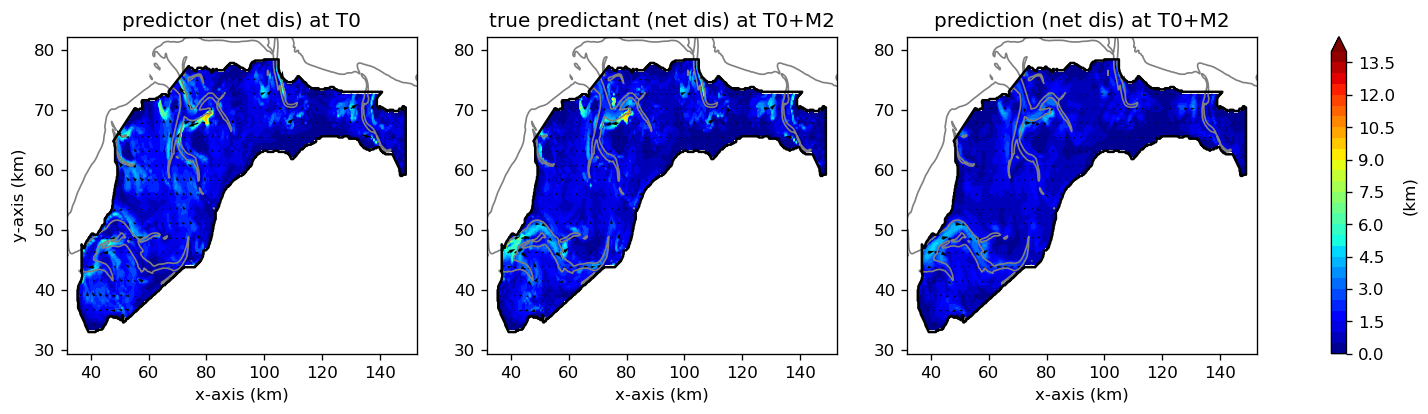

In [74]:
tt=str(times_test[ii0])[:19].replace(":","-")
plotting_test(ii0,tt)

2012-11-24T17-12-46
rmse_dx=11.75km, rmse_dy=6.36km, sqrt(mse_dx+mse_dy)=13.36km, rmse_magnitude=11.60km
standarized mse_dx+mse_dy = 13.47



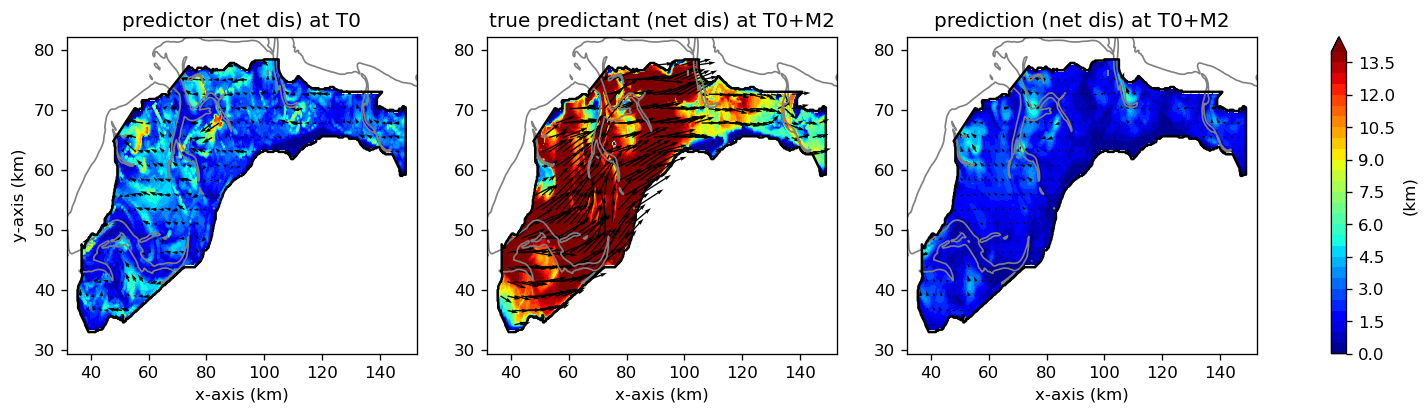

In [75]:
tt=str(times_test[ii1])[:19].replace(":","-")
plotting_test(ii1,tt)

2012-11-25T05-38-00
rmse_dx=2.72km, rmse_dy=2.25km, sqrt(mse_dx+mse_dy)=3.53km, rmse_magnitude=2.31km
standarized mse_dx+mse_dy = 1.08



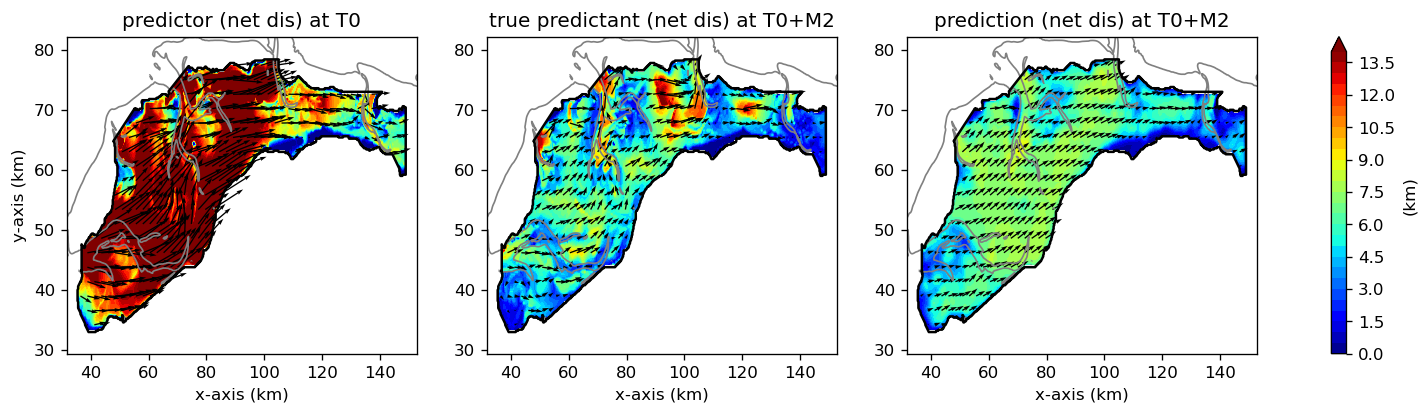

In [76]:
tt=str(times_test[ii1+1])[:19].replace(":","-")
plotting_test(ii1+1,tt)

In [ ]:
### circular mean and std of angles (without taking into account the magnitude of vector)
#
#https://en.wikipedia.org/wiki/Directional_statistics#The_fundamental_difference_between_linear_and_circular_statistics


# def _circfuncs_common2(samples, high, low):
#     # Ensure samples are array-like and size is not zero
#     samples = np.asarray(samples)
#     if samples.size == 0:
#         return np.nan, np.asarray(np.nan), np.asarray(np.nan)

#     # Recast samples as radians that range between 0 and 2 pi and calculate
#     # the sine and cosine
#     sin_samp = sin((samples - low)*2.*pi / (high - low))
#     cos_samp = cos((samples - low)*2.*pi / (high - low))

#     return samples, sin_samp, cos_samp


# def circstd2(samples, high=2*pi, low=0, axis=None):
#     samples, sin_samp, cos_samp = _circfuncs_common2(samples, high, low)
#     sin_mean = sin_samp.mean(axis=axis)
#     cos_mean = cos_samp.mean(axis=axis)
#     # hypot can go slightly above 1 due to rounding errors
#     print(sin_mean, cos_mean,hypot(sin_mean, cos_mean))
#     with np.errstate(invalid='ignore'):
#         R = np.minimum(1, hypot(sin_mean, cos_mean))
#         print(R)

#     return  sqrt(-2*log(R))


# num_epochs=100
# from scipy.stats import circmean,circstd
# from numpy import (isscalar, r_, log, around, unique, asarray, zeros,
#                    arange, sort, amin, amax, atleast_1d, sqrt, array,
#                    compress, pi, exp, ravel, count_nonzero, sin, cos,
#                    arctan2, hypot)
# a=np.linspace(0,2*np.pi,2000)
# sin_mean=np.mean(np.sin(a)); cos_mean=np.mean(np.cos(a))
# print(sin_mean,cos_mean)
# R=hypot(sin_mean, cos_mean)
# print(R)
# circstd(a),circstd2(a),sqrt(-2*log(R))